In [1]:
import numpy as np
import pandas as pd

import seaborn as sbn
import datetime

import matplotlib.pyplot as plt
from matplotlib import rcParams  
rcParams['figure.figsize'] = (15, 15) #Size of figure  
rcParams['figure.dpi'] = 125
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['text.latex.preamble'] = "\usepackage{subdepth}, \usepackage{type1cm}"
% matplotlib inline

## plotting spatial stuff

In [3]:
pos = pd.read_csv('inferred_locations.csv')

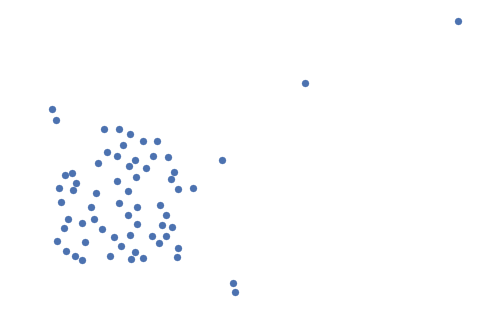

In [4]:
sbn.set(style="white")
plt.scatter(pos['x'],pos['y'])
sbn.despine(top=True, right=True, left=True, bottom=True, offset=None, trim=True)
plt.axis('off')
plt.savefig('locations.png', transparent=True)

## plotting mpc

In [2]:
import scipy.io as sio

In [3]:
mpcperfect = sio.loadmat('mpcperfect.mat')

In [4]:
mpcperfect

{'__globals__': [],
 '__header__': 'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Wed Jun  7 19:27:44 2017',
 '__version__': '1.0',
 'custWaiting': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'numVehiclesRebalancing': array([[ 0],
        [ 0],
        [ 0],
        ..., 
        [52],
        [52],
        [ 0]], dtype=uint16),
 'numVehiclesServing': array([[  0],
        [  0],
        [  0],
        ..., 
        [642],
        [643],
        [  0]], dtype=uint16)}

In [5]:
mpcperfect['numVehiclesRebalancing'][:,0].shape

(14400,)

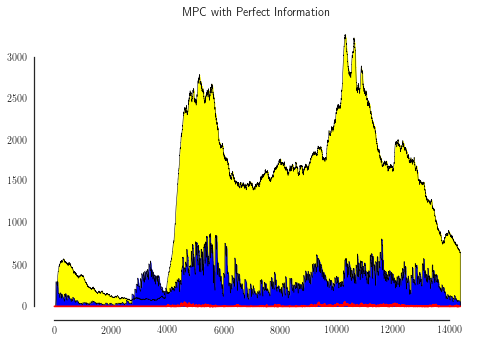

In [6]:
sbn.set(style="white")
plt.fill_between(range(14400),mpcperfect['numVehiclesServing'][:,0], color='yellow')
plt.plot(range(14400),mpcperfect['numVehiclesServing'][:,0], color='black', linewidth=0.5)
plt.fill_between(range(14400),mpcperfect['numVehiclesRebalancing'][:,0], color='blue')
plt.plot(range(14400),mpcperfect['numVehiclesRebalancing'][:,0], color='black', linewidth=0.5)
plt.plot(range(14400),mpcperfect['custWaiting'].sum(axis=1), color='red')

sbn.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=True)
plt.title('MPC with Perfect Information')

In [7]:
mpc_perfect = sio.loadmat('MPC-LSTM-PERFECT5000v_rev3.mat')
mpc_lstm = sio.loadmat('MPC-LSTM-SEAS5000v_rev3.mat')
reactive = sio.loadmat('REACTIVE5000v_rev3.mat')
mpc_empty = sio.loadmat('MPC-EMPTY5000v_rev3.mat')
mpc_naive = sio.loadmat('MPC-NAIVE5000v_rev3.mat')
mpc_lstm_milp = sio.loadmat('MPC-LSTM-SEAS-MILP5000v_rev3.mat')

In [8]:
scenarios = [
    {
        'data': mpc_perfect,
        'style': {
            'stroke': '--',
            'color': 'gray'
        },
        'name': 'MPC Perfect'
    },
    {
        'data': mpc_lstm,
        'style': {
            'stroke': '-',
            'color': 'green'
        },
        'name': 'MPC LSTM-LP'
    },
    {
        'data': reactive,
        'style': {
            'stroke': '-.',
            'color': '#E86100'
        },
        'name': 'Reactive'
    },
    {
        'data': mpc_naive,
        'style': {
            'stroke': '-.',
            'color': 'maroon'
        },
        'name': 'MPC Naive'
    },
    {
        'data': mpc_lstm_milp,
        'style': {
            'stroke': '-',
            'color': 'blue'
        },
        'name': 'MPC LSTM'
    },
    
    {
        'data': mpc_empty,
        'style': {
            'stroke': '-.',
            'color': 'green'
        },
        'name': 'TV-Reactive'
    },
]

In [9]:
for scenario in scenarios:
    scenario['data']['numVehiclesServing'] = scenario['data']['numVehiclesBusy']-scenario['data']['numVehiclesRebalancing']
    scenario['data']['totCustWaiting'] = scenario['data']['custWaiting'].sum(axis=1)
    scenario['data']['totCustUnassigned'] = scenario['data']['custUnassigned'].sum(axis=1)
    scenario['data']['totRebTasks'] = scenario['data']['numRebTasks'].sum(axis=1)
    scenario['data']['numVehiclesEmptyTravel'] = scenario['data']['numVehiclesDrivingToPickup']+scenario['data']['numVehiclesRebalancing']
    scenario['data']['utilizationRate'] = 1 - (scenario['data']['numVehiclesIdle'] / scenario['data']['v'][0][0].astype(np.float64))
    scenario['data']['numVehiclesEmptyTravelSmooth'] = pd.rolling_mean(np.array(scenario['data']['numVehiclesEmptyTravel']), 50, min_periods=1)

/Users/ramoniglesias/development/cs341/venv/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  


In [10]:
scenario['data']['numVehiclesEmptyTravel'].shape

(14400, 1)

In [11]:
14400 / 50

288

In [12]:
for scenario in scenarios:
    print scenario['name'],scenario['data']['allWaitTimes'].mean(),np.median(scenario['data']['allWaitTimes'])

MPC Perfect 3.6719160105 0.0
MPC LSTM-LP 28.4293813118 0.0
Reactive 283.304328798 72.0
MPC Naive 48.2151626084 0.0
MPC LSTM 29.3802802353 0.0
TV-Reactive 543.462500495 414.0


In [13]:
for scenario in scenarios:
    print scenario['name'],scenario['data']['numDelivered'][0][0]

MPC Perfect 329184
MPC LSTM-LP 329148
Reactive 329029
MPC Naive 329165
MPC LSTM 329152
TV-Reactive 328391


In [14]:
for scenario in scenarios:
    print scenario['name'],scenario['data']['totRebTasks'][mask3].sum()

MPC Perfect

NameError: name 'mask3' is not defined

In [15]:
for scenario in scenarios:
    print scenario['name'],scenario['data']['numVehiclesEmptyTravel'][mask3].mean()

 MPC Perfect

NameError: name 'mask3' is not defined

In [16]:
for scenario in scenarios:
    print scenario['name'],scenario['data']['totCustWaiting'].max()

 MPC Perfect 323
MPC LSTM-LP 843
Reactive 8892
MPC Naive 2286
MPC LSTM 926
TV-Reactive 11989


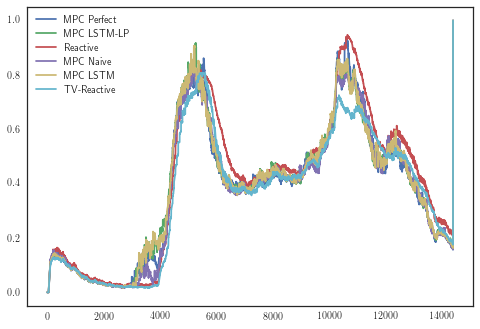

In [17]:
for scenario in scenarios:
    plt.plot(#scenario['data']['numVehiclesDrivingToPickup'],
             1 - scenario['data']['numVehiclesIdle'] / 5000.,# + 
             #scenario['data']['numVehiclesRebalancing'],
        label=scenario['name']
    )
plt.legend();

In [18]:

pd.rolling_mean(np.array([1,2,3,4]), 3, center=True, min_periods=1)

/Users/ramoniglesias/development/cs341/venv/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  


array([ 1.5,  2. ,  3. ,  3.5])

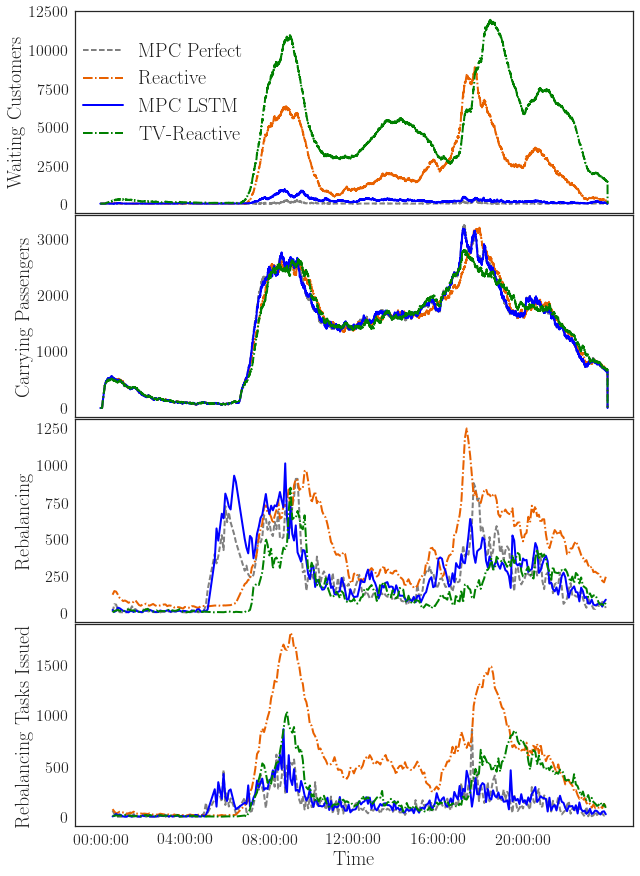

In [19]:
sbn.set(style="white")

titles = [
    'Waiting Customers',
    'Carrying Passengers', 
    'Rebalancing', 
    'Rebalancing Tasks Issued',
          #'Unassigned Customers',
          #'Utilization Rate'
         ]
series = ['totCustWaiting',
          'numVehiclesDrivingToDest', 
          'numVehiclesEmptyTravelSmooth',
          'totRebTasks', 
          #'totCustUnassigned',
          #'utilizationRate'
         ]

start = datetime.datetime(2016, 1, 21, hour =0)
stepsize = datetime.timedelta(seconds = 6)
tindex = np.array([(start + stepsize * j).time() for j in range(14400)])
mask3 = (scenario['data'][series[3]] > 0)
mask = np.array([True for i in range(len(tindex))])
mask_axes = np.array([(t.hour % 4 == 0) and (t.minute == 0) and (t.second == 0) for t in tindex])

masks = [
    mask,
    mask,
    mask3,
    mask3,
    mask,
    mask,
]



f, axes = plt.subplots(len(titles), sharex=True, sharey=False,figsize=(10,15));
for i in range(len(titles)):
    for j, scenario in enumerate(scenarios):
        if j not in [0,2,4,5]: continue
        axes[i].plot(
            tindex[masks[i]], scenario['data'][series[i]][masks[i]],
            color = scenario['style']['color'],
            linestyle = scenario['style']['stroke'],
            linewidth=2,
            label = scenario['name']
                );
        axes[i].set_ylabel(titles[i], fontsize=20)
        axes[i].tick_params(labelsize=16)

f.subplots_adjust(hspace=0.01);
axes[-1].set_xlabel('Time', fontsize = 20)
axes[0].legend(loc=(0,0.3), fontsize = 20)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False);
axes[-1].set_xticks(tindex[mask_axes])
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "Computer Modern Roman"
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['text.usetex'] = True
plt.rcParams['xtick.labelsize'] = 24
plt.savefig('summarized_results_plot.pdf',bbox_inches='tight')

In [24]:
np.__version__

'1.12.1'

In [21]:
import matplotlib
print matplotlib.__version__

2.0.0


In [ ]:
help(axes[-1].set_xticks)

In [ ]:
scenario['data'][series[3]] > 0

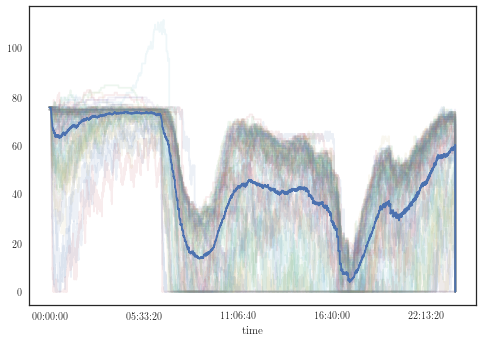

In [474]:
#plt.plot(tindex,mpc_lstm['custUnassigned'], alpha=0.1);
plt.plot(tindex,reactive['carsIdlePrint'], alpha=0.1);
plt.plot(tindex,reactive['numVehiclesIdle']/66.);
    
#plt.ylim(0,200)

(0, 200)

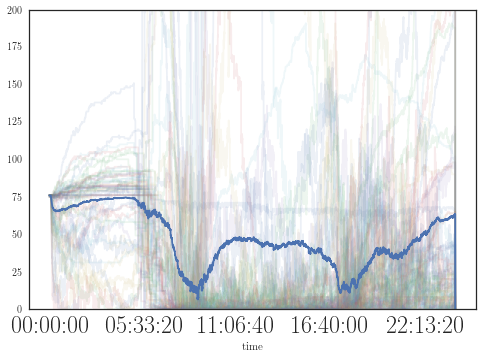

In [116]:
#plt.plot(tindex,mpc_lstm['custUnassigned'], alpha=0.1);
plt.plot(tindex,mpc_seas['carsIdlePrint'], alpha=0.1);
plt.plot(tindex,mpc_seas['numVehiclesIdle']/66.);
    

plt.ylim(0,200)

## plotting predictions

In [20]:
paxout = pd.read_csv('ignored_assets/paxout_table.csv')
paxout['time_bucket'] = pd.to_datetime(paxout['time_bucket'])
real = paxout[paxout['time_bucket'].dt.date == datetime.date(2016, 1, 21)]
real = real.set_index('time_bucket')

/Users/ramoniglesias/development/cs341/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


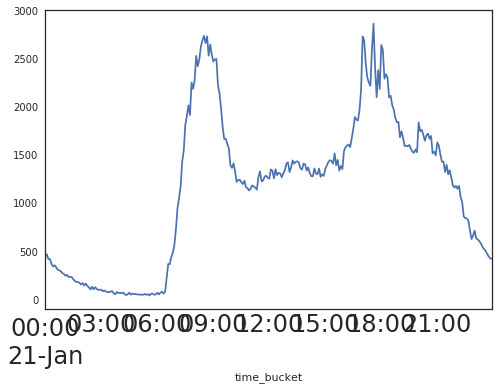

In [21]:
plt.rcParams['text.usetex'] = False
real.sum(axis=1).plot()

In [22]:
# params
stepsize = pd.Timedelta('5 min')
horizon = pd.Timedelta('2 hour')
start = pd.to_datetime('2016-01-21 00:00:00')
end = pd.to_datetime('2016-01-22 00:00:00')

lstmdf = pd.read_csv('ignored_assets/new_lstm_to_pred.csv')
lstmdf['predicted_at'] = pd.to_datetime(lstmdf['predicted_at'])
lstmdf['time_bucket'] = pd.to_datetime(lstmdf['timestamp'])
lstmdf = lstmdf.drop('timestamp', axis = 1)

wrong_vals = lstmdf['time_bucket'][lstmdf['time_bucket'] >= pd.to_datetime('2016-01-22T00:00:00.000000000')].unique()
corrected_vals = [pd.to_datetime('2016-01-22T00:00:00.000000000') + j*stepsize for j in range(int(horizon / stepsize))]
for i in range(len(wrong_vals)):
    lstmdf['time_bucket'][lstmdf['time_bucket'] == wrong_vals[i]] = corrected_vals[i]

/Users/ramoniglesias/development/cs341/venv/lib/python2.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


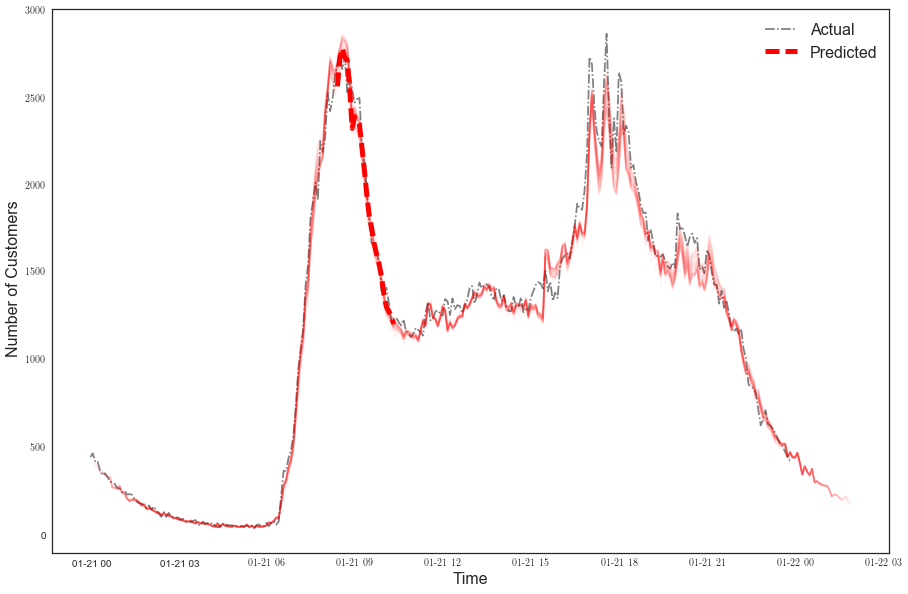

In [23]:
sbn.set(style="white")
plt.figure(figsize=(15,10))
plt.plot(real.index, real.sum(axis=1).values, color='gray', linestyle='-.', label='Actual')

for i,t in enumerate(real.index):
    #if i % 12 != 0: continue
    tempdf = lstmdf[lstmdf['predicted_at'] == t].drop('predicted_at',axis=1).set_index('time_bucket').sum(axis=1)
    if i == 100:
        plt.plot(tempdf.index, tempdf.values.round(), color='r', linestyle='--', alpha=1,linewidth=5, label='Predicted')
    else:
        plt.plot(tempdf.index, tempdf.values.round(), color='r', linestyle='-', alpha=0.05)

plt.ylabel('Number of Customers', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.legend(fontsize = 16)
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "Computer Modern Roman"
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['text.usetex'] = True
plt.savefig('total_demand_predictions.pdf',bbox_inches='tight')

In [41]:
tempdf.index[tempdf.index<datetime.datetime(2016,1,22)].time

array([], dtype=object)

In [42]:
tempdf.index

DatetimeIndex(['2016-01-22 00:00:00', '2016-01-22 00:05:00',
               '2016-01-22 00:10:00', '2016-01-22 00:15:00',
               '2016-01-22 00:20:00', '2016-01-22 00:25:00',
               '2016-01-22 00:30:00', '2016-01-22 00:35:00',
               '2016-01-22 00:40:00', '2016-01-22 00:45:00',
               '2016-01-22 00:50:00', '2016-01-22 00:55:00',
               '2016-01-22 01:00:00', '2016-01-22 01:05:00',
               '2016-01-22 01:10:00', '2016-01-22 01:15:00',
               '2016-01-22 01:20:00', '2016-01-22 01:25:00',
               '2016-01-22 01:30:00', '2016-01-22 01:35:00',
               '2016-01-22 01:40:00', '2016-01-22 01:45:00',
               '2016-01-22 01:50:00', '2016-01-22 01:55:00'],
              dtype='datetime64[ns]', name=u'time_bucket', freq=None)

In [43]:
real.index

DatetimeIndex(['2016-01-21 00:00:00', '2016-01-21 00:05:00',
               '2016-01-21 00:10:00', '2016-01-21 00:15:00',
               '2016-01-21 00:20:00', '2016-01-21 00:25:00',
               '2016-01-21 00:30:00', '2016-01-21 00:35:00',
               '2016-01-21 00:40:00', '2016-01-21 00:45:00',
               ...
               '2016-01-21 23:10:00', '2016-01-21 23:15:00',
               '2016-01-21 23:20:00', '2016-01-21 23:25:00',
               '2016-01-21 23:30:00', '2016-01-21 23:35:00',
               '2016-01-21 23:40:00', '2016-01-21 23:45:00',
               '2016-01-21 23:50:00', '2016-01-21 23:55:00'],
              dtype='datetime64[ns]', name=u'time_bucket', length=288, freq=None)

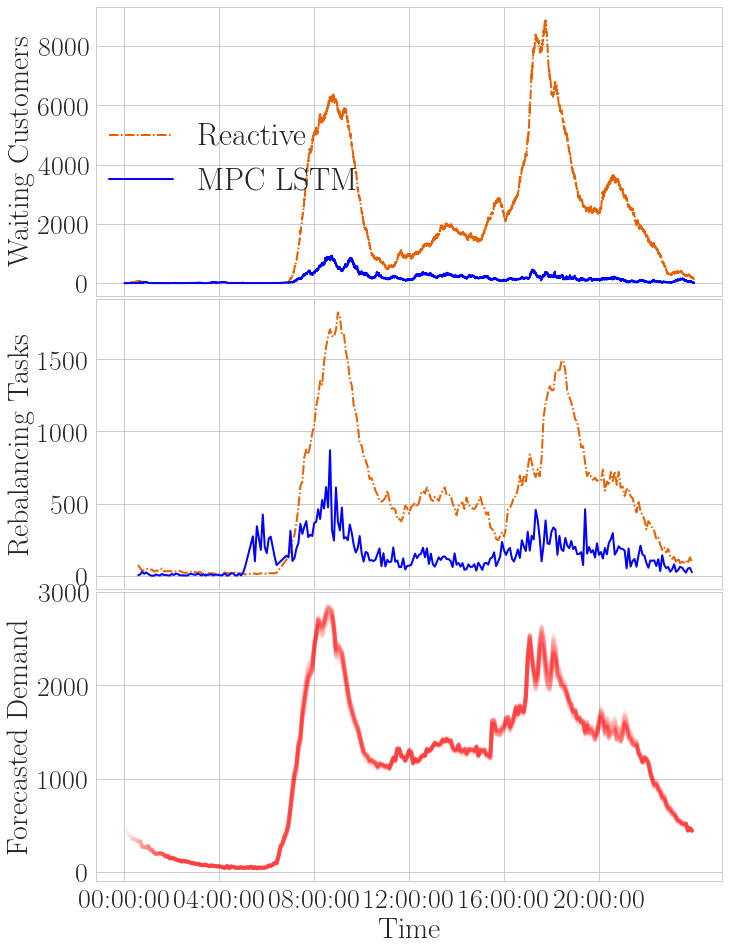

In [57]:
plt.style.use(['fivethirtyeight','seaborn-white','seaborn-whitegrid'])

titles = [
    'Waiting Customers',
    #'Carrying Passengers', 
    #'Rebalancing', 
    'Rebalancing Tasks',
          #'Unassigned Customers',
          #'Utilization Rate'
         ]
series = ['totCustWaiting',
          #'numVehiclesDrivingToDest', 
          #'numVehiclesEmptyTravelSmooth',
          'totRebTasks', 
          #'totCustUnassigned',
          #'utilizationRate'
         ]

masks = [
    mask,
    #mask,
    mask3,
    #mask3,
    #mask,
    #mask,
]



f, axes = plt.subplots(3, sharex=True, sharey=False,figsize=(10,15));
for i in range(len(titles)):
    for j, scenario in enumerate(scenarios):
        if j not in [2,4]: continue
        axes[i].plot(
            tindex[masks[i]], scenario['data'][series[i]][masks[i]],
            color = scenario['style']['color'],
            linestyle = scenario['style']['stroke'],
            linewidth=2,
            label = scenario['name']
                );
        axes[i].set_ylabel(titles[i], fontsize=30)
        axes[i].tick_params(labelsize=28)


for i,t in enumerate(real.index):
    #if i % 12 != 0: continue
    tempdf = lstmdf[lstmdf['predicted_at'] == t].drop('predicted_at',axis=1).set_index('time_bucket').sum(axis=1)
    tempdf = tempdf[tempdf.index < datetime.datetime(2016,1,22)]
    if i == 100000:
        axes[2].plot(tempdf.index.time, tempdf.values.round(), color='r', linestyle='--', alpha=1,linewidth=5, label='Predicted')
    else:
        axes[2].plot(tempdf.index.time, tempdf.values.round(), color='r', linestyle='-', alpha=0.05)

axes[2].set_ylabel('Forecasted Demand', fontsize=30)
axes[2].tick_params(labelsize=28)
#axes[2].set_xlabel('Time', fontsize=20)
        
f.subplots_adjust(hspace=0.01);
axes[-1].set_xlabel('Time', fontsize = 30)
axes[0].legend(loc=(0,0.3), fontsize = 32)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False);
axes[-1].set_xticks(tindex[mask_axes])
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "Computer Modern Roman"
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['text.usetex'] = True
plt.rcParams['xtick.labelsize'] = 24
plt.savefig('summarized_results_plot.pdf',bbox_inches='tight', transparent=True)

In [23]:
for scenario in scenarios:
    print scenario['name'],scenario['data']['numVehiclesEmptyTravel'].mean()

MPC Perfect 225.962916667
MPC LSTM-Tommy 217.751597222
Reactive 381.485902778
MPC Naive 198.177708333
MPC LSTM-Seas 252.149444444


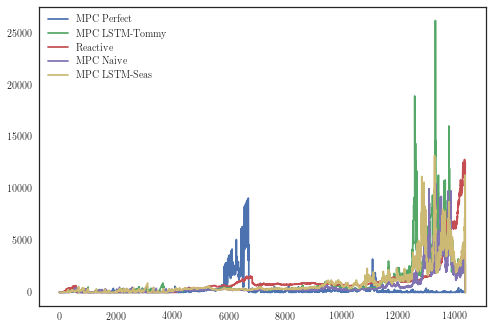

In [24]:
for scenario in scenarios:
    plt.plot(scenario['data']['avgWaitTimes'], label=scenario['name'])

plt.legend()

# Spurious: this is the average for unpicked customers, thus the MPC formulations, who have less waiting customers,
# have largers swings

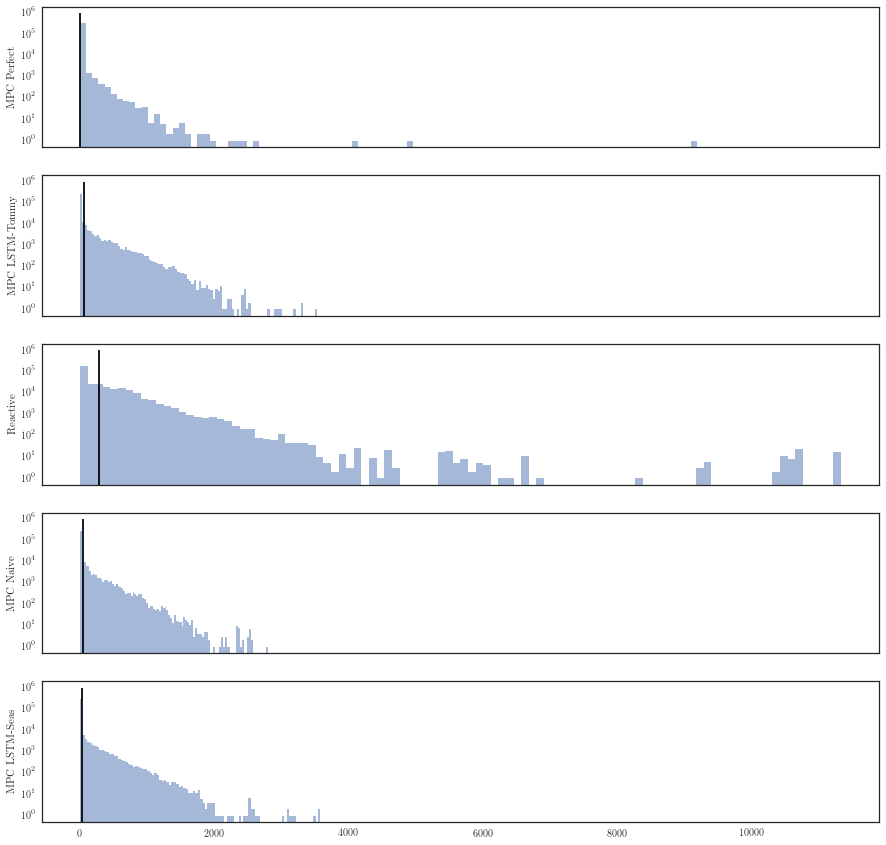

In [26]:
f, axes = plt.subplots(len(scenarios), sharex=True, sharey=False,figsize=(15,15));
for i,scenario in enumerate(scenarios):
    axes[i].hist(scenario['data']['allWaitTimes'], label=scenario['name'], alpha=0.5,
             #bins=np.concatenate((np.array([0]),np.logspace(0.0, 3.0, 100))),
                 bins=100,
                );
    axes[i].vlines(scenario['data']['allWaitTimes'].mean(), 0, 10e5)
    axes[i].set_ylabel(scenario['name'])
    axes[i].set_yscale('log')

#plt.xscale('log')

In [27]:
for scenario in scenarios:
    print scenario['name'], scenario['data']['allWaitTimes'].mean()

MPC Perfect 3.9017305747
MPC LSTM-Tommy 57.7504056296
Reactive 283.304328798
MPC Naive 48.2151626084
MPC LSTM-Seas 28.4293813118


In [28]:
for scenario in scenarios:
    print scenario['name'], scenario['data']['allWaitTimes'].max()

MPC Perfect 9198
MPC LSTM-Tommy 3534
Reactive 11334
MPC Naive 2802
MPC LSTM-Seas 3582


In [29]:
for scenario in scenarios:
    print scenario['name'], (scenario['data']['cumNumCustomers'][-2] + scenario['data']['numDelivered'] + scenario['data']['numVehiclesDrivingToDest'][-2])[0][0]

MPC Perfect 329811
MPC LSTM-Tommy 329810
Reactive 329814
MPC Naive 329810
MPC LSTM-Seas 329800


In [371]:
unpicked = np.zeros(66)
picked_not_del = np.zeros(66)
delivered = np.zeros(66)
incongruent = np.zeros(66)
self_looper = np.zeros(66)
for i in range(scenario['data']['cc'] - 1):
    cus = scenario['data']['customer'][0][i]
    # unpicked
    if cus[-2][0][0] == 0:
        unpicked[cus[2]-1] += 1
    elif cus[-1][0][0] == 0:
        picked_not_del[cus[2]-1] += 1
    else:
        delivered[cus[2]-1] += 1
    
    if cus[-2][0][0] == 0 and cus[-1][0][0] == 1:
        incongruent[cus[2]-1] += 1
    
    if cus[2] == cus[3]:
        self_looper[cus[2]-1] += 1

### forecasting horizons

In [332]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
horizons_results = sio.loadmat('ignored_assets/explore_horizons_results.mat')

In [333]:

class MyAxes3D(Axes3D):

    def __init__(self, baseObject, sides_to_draw):
        self.__class__ = type(baseObject.__class__.__name__,
                              (self.__class__, baseObject.__class__),
                              {})
        self.__dict__ = baseObject.__dict__
        self.sides_to_draw = list(sides_to_draw)
        self.mouse_init()

    def set_some_features_visibility(self, visible):
        for t in self.w_zaxis.get_ticklines() + self.w_zaxis.get_ticklabels():
            t.set_visible(visible)
        self.w_zaxis.line.set_visible(visible)
        self.w_zaxis.pane.set_visible(visible)
        self.w_zaxis.label.set_visible(visible)

    def draw(self, renderer):
        # set visibility of some features False 
        self.set_some_features_visibility(False)
        # draw the axes
        super(MyAxes3D, self).draw(renderer)
        # set visibility of some features True. 
        # This could be adapted to set your features to desired visibility, 
        # e.g. storing the previous values and restoring the values
        self.set_some_features_visibility(True)

        zaxis = self.zaxis
        draw_grid_old = zaxis.axes._draw_grid
        # disable draw grid
        zaxis.axes._draw_grid = False

        tmp_planes = zaxis._PLANES

        if 'l' in self.sides_to_draw :
            # draw zaxis on the left side
            zaxis._PLANES = (tmp_planes[2], tmp_planes[3],
                             tmp_planes[0], tmp_planes[1],
                             tmp_planes[4], tmp_planes[5])
            zaxis.draw(renderer)
        if 'r' in self.sides_to_draw :
            # draw zaxis on the right side
            zaxis._PLANES = (tmp_planes[3], tmp_planes[2], 
                             tmp_planes[1], tmp_planes[0], 
                             tmp_planes[4], tmp_planes[5])
            zaxis.draw(renderer)

        zaxis._PLANES = tmp_planes

        # disable draw grid
        zaxis.axes._draw_grid = draw_grid_old

In [334]:
X = horizons_results['results'][:,1].reshape((5,5)) # look forward
Y = horizons_results['results'][:,0].reshape((5,5)) # look backward
Z = horizons_results['results'][:,2].reshape((5,5)) # mean wait time

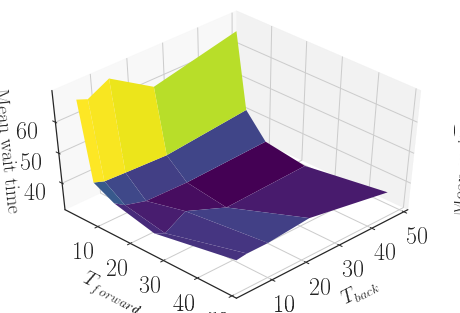

In [335]:
sbn.set_style("white")
fig = plt.figure()
ax = fig.gca(projection='3d')  
ax = fig.add_axes(MyAxes3D(ax, 'l'))
ax.plot_surface(X, Y, Z,             
                       rstride=1,           # row step size
                       cstride=1,           # column step size
                       cmap=cm.viridis,        # colour map
                       linewidth=1,         # wireframe line width
                       antialiased=True)
ax.view_init(45, -45)
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "Computer Modern Roman"
ax.set_xlabel('$T_{forward}$',fontsize=20, labelpad=20)
ax.set_ylabel('$T_{back}$',fontsize=20,labelpad=20)
ax.set_zlabel('Mean wait time',fontsize=20,labelpad=8)
fig.savefig('3dplot.pdf')#,bbox_inches='tight')

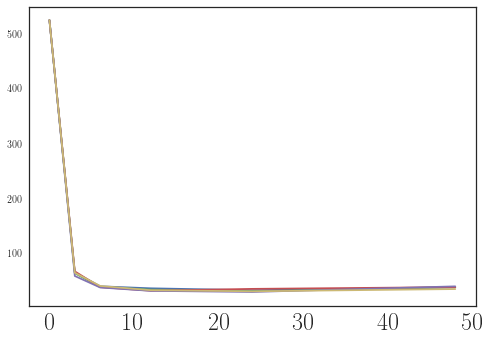

In [336]:
Q = np.zeros((Z.shape[1] + 1, Z.shape[0]))
Q[1:,:] = Z.T
Q[0,:] = 525
plt.plot([0,3,6,12,24,48],Q)

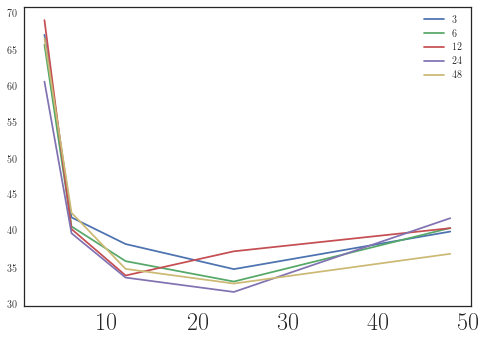

In [337]:
horizons = [3,6,12,24,48]
lineObjects = plt.plot(horizons,Z.T, label = horizons);
plt.legend(iter(lineObjects), horizons)

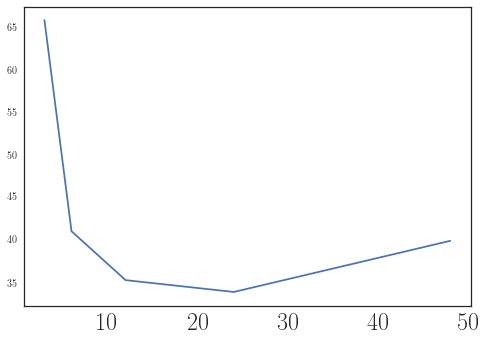

In [338]:
plt.plot(horizons,Z.T.mean(axis=1));

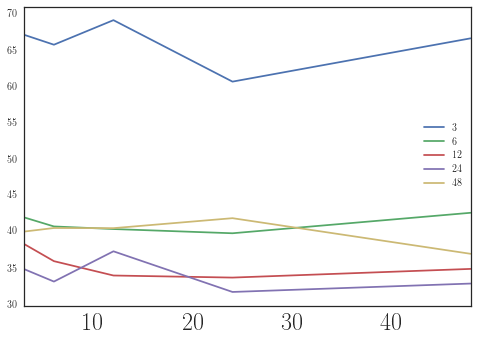

In [339]:
pd.DataFrame(Z, columns = horizons, index = horizons).plot()

## milp stuff

In [243]:
mpc_milp = sio.loadmat('MPC-LSTM-MILP-24b_48f_np5000v_rev3.mat')

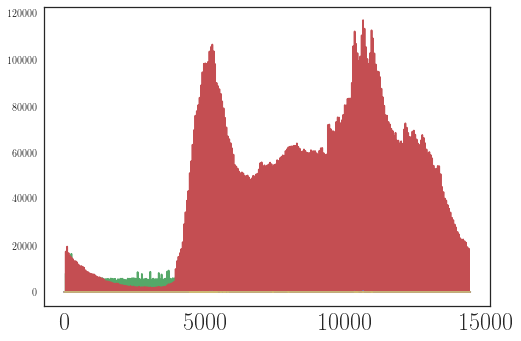

In [245]:
plt.plot(mpc_milp['milpOutputs'])

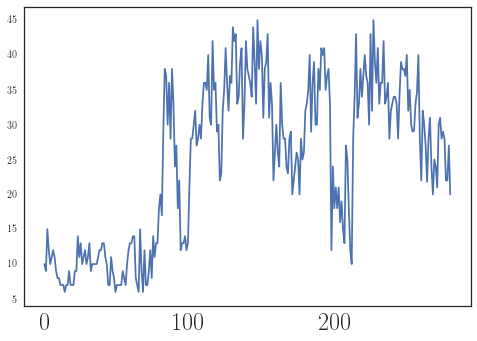

In [249]:
plt.plot(mpc_milp['milpOutputs'][mask3,0])

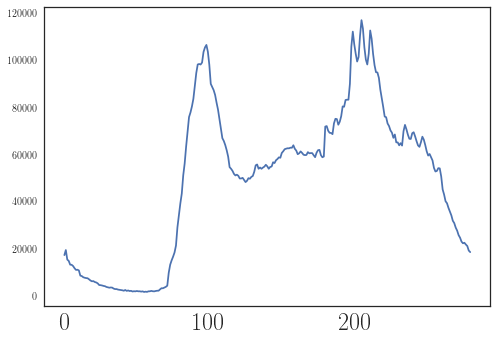

In [256]:
plt.plot(mpc_milp['milpOutputs'][mask3,2])

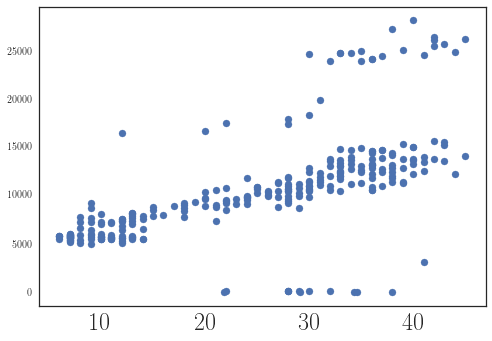

In [280]:
plt.scatter(mpc_milp['milpOutputs'][mask3,0], mpc_milp['milpOutputs'][mask3,1])

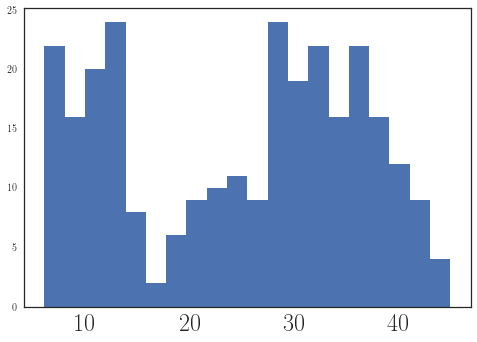

In [279]:
plt.hist(mpc_milp['milpOutputs'][mask3,0], bins=20);

In [270]:
mpc_milp['milpOutputs'][mask3,0].mean()

24.732626011363127

In [282]:
mpc_milp['milpOutputs'][mask3,0].std()

11.555955461670159